# Homework and bake-off: pragmatic color descriptions

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Summer 2022"

import os

if 'IS_GRADESCOPE_ENV' not in os.environ:
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/gdrive')

    # TODO: Enter the foldername in your Drive where you have saved the unzipped
    FOLDERNAME = 'MyDrive/cs224u'
    assert FOLDERNAME is not None, "[!] Enter the foldername."

    # Now that we've mounted your Drive, this ensures that
    # the Python interpreter of the Colab VM can load
    # python files from within it.
    import sys
    sys.path.append('/content/gdrive/{}'.format(FOLDERNAME))

    %cd /content/gdrive/$FOLDERNAME

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/cs224u


In [2]:
from colors import ColorsCorpusReader
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_color_describer import ContextualColorDescriber
from torch_color_describer import create_example_dataset

import utils
from utils import START_SYMBOL, END_SYMBOL, UNK_SYMBOL

In [3]:
utils.fix_random_seeds()

In [4]:
COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "filteredCorpus.csv")

## All two-word examples as a dev corpus

So that you don't have to sit through excessively long training runs during development, I suggest working with the two-word-only subset of the corpus until you enter into the late stages of system testing.

In [5]:
dev_corpus = ColorsCorpusReader(
    COLORS_SRC_FILENAME,
    #word_count=2,
    normalize_colors=True)

In [6]:
dev_examples = list(dev_corpus.read())

This subset has about one-third the examples of the full corpus:

In [7]:
len(dev_examples)

46994

We __should__ worry that it's not a fully representative sample. Most of the descriptions in the full corpus are shorter, and a large proportion are longer. So this dataset is mainly for debugging, development, and general hill-climbing. All findings should be validated on the full dataset at some point.

## Dev dataset

The first step is to extract the raw color and raw texts from the corpus:

In [8]:
dev_rawcols, dev_texts = zip(*[[ex.colors, ex.contents] for ex in dev_examples])

The darker blue one


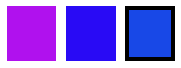

In [9]:
next(dev_corpus.read()).display()

The raw color representations are suitable inputs to a model, but the texts are just strings, so they can't really be processed as-is. Question 1 asks you to do some tokenizing!

## Random train–test split for development

For the sake of development runs, we create a random train–test split:

In [10]:
#dev_rawcols_train, dev_rawcols_test, dev_texts_train, dev_texts_test = \
#    train_test_split(dev_rawcols, dev_texts)

#dev_rawcols_test, dev_rawcols_train = dev_rawcols[:3473], dev_rawcols[3473:]
#dev_texts_test, dev_texts_train = dev_texts[:3473], dev_texts[3473:]

dev_rawcols_train = dev_rawcols
dev_texts_train = dev_texts

## Question 1: Improve the tokenizer [1 point]

This is the first required question – the first required modification to the default pipeline.

The function `tokenize_example` simply splits its string on whitespace and adds the required start and end symbols:

In [11]:
def tokenize_example(s, vocab = None):
    import string
    import re
    
    endings = ["er", "est", "ish"]

    s = s.lower()
    r = re.compile(r'[\s{}]+'.format(re.escape(string.punctuation)))
    words = r.split(s)
    split = []
    
    for w in words:
        if w[-2:] == "er":
            w = w[:-2]
        elif w[-3:] == "est" or w[-3:] == "ish":
            w = w[:-3]

        if vocab is not None:
            if w not in vocab:
                w = w.replace(w, '$UNK')

        if w != '':
            split.append(w)
        
    return [START_SYMBOL] + split + [END_SYMBOL]

In [12]:
tokenize_example(dev_texts_train[386])

['<s>', 'brown', '</s>']

__Your task__: Modify `tokenize_example` so that it does something more sophisticated with the input text. 

__Notes__:

* There are useful ideas for this in [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142)
* There is no requirement that you do word-level tokenization. Sub-word and multi-word are options.
* This question can interact with the size of your vocabulary (see just below), and in turn with decisions about how to use `UNK_SYMBOL`.

__Important__: don't forget to add the start and end symbols, else the resulting models will definitely be terrible! The following test will check that your tokenizer has this property:

In [13]:
def test_tokenize_example(func):
    s = "A test string"
    result = func(s)
    assert all(isinstance(tok, str) for tok in result), \
        "The tokenizer must return a list of strings."
    assert result[0] == START_SYMBOL, \
        "The tokenizer must add START_SYMBOL as the first token."
    assert result[-1] == END_SYMBOL, \
        "The tokenizer must add END_SYMBOL as the final token."

In [14]:
dev_seqs_train = [tokenize_example(s) for s in dev_texts_train]

#dev_seqs_test = [tokenize_example(s) for s in dev_texts_test]

In [15]:
#Standard dev_vocab method
dev_vocab = sorted({w for toks in dev_seqs_train for w in toks})

#Remove words that only appear once
#from collections import Counter
#count_dict = Counter([w for toks in dev_seqs_train for w in toks])
#dev_vocab = sorted({tok for tok, count in count_dict.items() if count > 1})

#Replace all words that only appear once in training set with UNK_SYMBOL
#dev_seqs_train = [tokenize_example(s, dev_vocab) for s in dev_texts_train]

dev_vocab += [UNK_SYMBOL]

In [16]:
len(dev_vocab)

2941

## Question 2: Improve the color representations [1 point]

This is the second required pipeline improvement for the assignment. 

The following functions do nothing at all to the raw input colors we get from the corpus. 

In [17]:
from vectorizers import FourierVectorizer

In [18]:
def represent_color_context(colors):

    return [represent_color(color) for color in colors]

def represent_color(color):
    from itertools import product
    
    color0 = color[0]
    color1 = color[1]
    color2 = color[2]
    
    h = color0 
    v = color1 + color2 * min(color1, 1 - color1)
    if v == 0:
        s = 0
    else:
        s = 2 * (1 - color1 / v)
    color_rep = np.zeros((3, 3, 3, 2))

    for j, k, l in product((0, 1, 2), repeat=3):    
        f_hat = np.exp(-2 * np.pi * complex(0, (j * h + k * s + l * v)))
        color_rep[j, k, l, 0] = f_hat.real
        color_rep[j, k, l, 1] = f_hat.imag
    
    return color_rep.transpose(3, 0, 1, 2).flatten().tolist()

In [19]:
dev_cols_train = [represent_color_context(colors) for colors in dev_rawcols_train]

#dev_cols_test = [represent_color_context(colors) for colors in dev_rawcols_test]

In [20]:
GLOVE_HOME = os.path.join('data', 'glove.6B')

def create_glove_embedding(vocab, glove_base_filename='glove.6B.50d.txt'):
    # Use `utils.glove2dict` to read in the GloVe file:

    data = utils.glove2dict(os.path.join(GLOVE_HOME, glove_base_filename))

    embedding, vocab = utils.create_pretrained_embedding(data, vocab)

    return embedding, vocab

dev_glove_embedding, dev_glove_vocab = create_glove_embedding(dev_vocab)
print(dev_glove_embedding.shape)
print(dev_glove_vocab)

(2941, 50)
['0', '1', '10', '13', '14', '15', '2', '20', '2012', '2nd', '3', '30', '30s', '3rd', '4', '40', '49', '50', '6', '7', '80', '80s', '</s>', '<s>', 'a', 'aaagh', 'able', 'about', 'abright', 'absence', 'accurate', 'ack', 'acronynyms', 'actual', 'actually', 'add', 'added', 'address', 'advancing', 'aft', 'again', 'ago', 'agree', 'agreed', 'ah', 'ahah', 'ahaha', 'ahahha', 'ahh', 'ahhh', 'ahhhh', 'ahint', 'ain', 'air', 'airline', 'airport', 'aka', 'album', 'alike', 'alittle', 'alive', 'all', 'allowed', 'almost', 'almosy', 'almsot', 'alomst', 'aloud', 'alright', 'also', 'although', 'always', 'am', 'amazing', 'american', 'amethyst', 'among', 'amost', 'amount', 'an', 'and', 'angry', 'anoth', 'answ', 'any', 'anymore', 'anyone', 'anything', 'anytime', 'anyway', 'anyways', 'apologize', 'apparel', 'appear', 'appears', 'appicane', 'applciane', 'apple', 'apples', 'appliance', 'applicance', 'apply', 'apposed', 'appreciate', 'aqua', 'aquamarine', 'aquarium', 'aquas', 'arange', 'are', 'aren',

# Transformer Model & Experiments

In [21]:
import torch

class ColorDataset(torch.utils.data.Dataset):
    """
    PyTorch dataset for contextual color describers. The primary
    function of this dataset is to organize the raw data into
    batches of Tensors of the appropriate shape and type. When
    using this dataset with `torch.utils.data.DataLoader`, it is
    crucial to supply the `collate_fn` method as the argument for
    the `DataLoader.collate_fn` parameter.

    Parameters
    ----------
    color_seqs : list of lists of lists of floats, or np.array
        Dimension (m, n, p) where m is the number of examples, n is
        the number of colors in each context, and p is the length
        of the color representations.

    word_seqs : list of list of int
        Dimension m, the number of examples. The length of each
        sequence can vary.

    ex_lengths : list of int
        Dimension m. Each value gives the length of the corresponding
        word sequence in `word_seqs`.

    """
    def __init__(self, color_seqs, word_seqs, ex_lengths):
        assert len(color_seqs) == len(ex_lengths)
        assert len(color_seqs) == len(word_seqs)
        self.color_seqs = color_seqs
        self.word_seqs = word_seqs
        self.ex_lengths = ex_lengths

    @staticmethod
    def collate_fn(batch):
        """
        Function for creating batches.

        Parameter
        ---------
        batch : tuple of length 3
            Contains the `color_seqs`, `word_seqs`, and `ex_lengths`,
            all as lists or similar Python iterables. The function
            turns them into Tensors.

        Returns
        -------
        color_seqs : torch.FloatTensor.
             The shape is `(m, n, p)` where `m` is the batch_size,
             `n` is the number of colors in each context, and `p` is
             the color dimensionality.

        word_seqs : torch.LongTensor
            This is a padded sequence, dimension (m, k), where `m` is
            the batch_size and `k` is the length of the longest sequence
            in the batch.

        ex_lengths : torch.LongTensor
            The true lengths of each sequence in `word_seqs. This will
            have shape `(m, )`, where `m` is the batch_size.

        targets :  torch.LongTensor
            This is a padded sequence, dimension (m, k-1), where `m` is
            the batch_size and `k` is the length of the longest sequence
            in the batch. The targets match `word_seqs` except we drop the
            first symbol, as it is always START_SYMBOL. When the loss is
            calculated, we compare this sequence to `word_seqs` excluding
            the final character, which is always the END_SYMBOL. The result
            is that each timestep t is trained to predict the symbol
            at t+1.

        """
        color_seqs, word_seqs, ex_lengths = zip(*batch)
        # Conversion to Tensors:
        color_seqs = torch.FloatTensor(color_seqs)
        word_seqs = [torch.LongTensor(seq) for seq in word_seqs]
        ex_lengths = torch.LongTensor(ex_lengths)
        # Targets as next-word predictions:
        targets = [x[1:, ] for x in word_seqs]
        # Word Inputs:
        inputs = [x[:-1, ] for x in word_seqs]
        # Padding
        word_seqs = torch.nn.utils.rnn.pad_sequence(
            inputs, batch_first=True)
        targets = torch.nn.utils.rnn.pad_sequence(
            targets, batch_first=True)
        return color_seqs, word_seqs, ex_lengths, targets

    def __len__(self):
        return len(self.color_seqs)

    def __getitem__(self, idx):
        return self.color_seqs[idx], self.word_seqs[idx], self.ex_lengths[idx]

In [22]:
from torch_color_describer import EncoderDecoder, ContextualColorDescriber
import torch
import torch.nn as nn
from IPython.core.debugger import set_trace
import math

def create_pad_mask(matrix: torch.tensor, pad_token: int) -> torch.tensor:
      return (matrix == pad_token)

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.2, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerColorizedEncoderDecoder(nn.Module):

    def __init__(self, vocab_size, embedding, embed_dim, hidden_dim, 
                 transformer_args, device, freeze_embedding=False):
        super().__init__()

        nhead = transformer_args['nhead']
        num_encoder_layers = transformer_args['num_encoder_layers']
        num_decoder_layers = transformer_args['num_decoder_layers']
        dim_feedforward = transformer_args['dim_feedforward']
        dropout = transformer_args['dropout']

        self.color_dim = 54
        self.hidden_dim = hidden_dim
        self.rnn = nn.LSTM(
            input_size=self.color_dim,
            hidden_size=self.hidden_dim,
            #num_layers=3,
            bidirectional = True,
            batch_first=True)

        self.transformer_model = nn.Transformer(d_model = embed_dim, 
                                                batch_first = True, 
                                                nhead = nhead, 
                                                num_encoder_layers=num_encoder_layers,
                                                num_decoder_layers= num_decoder_layers,
                                                dim_feedforward = dim_feedforward,
                                                dropout = dropout)
        
        self.positionalEncoder = PositionalEncoding(d_model = embed_dim)
        self.outputter = nn.Linear(embed_dim, vocab_size)
        self.freeze_embedding = freeze_embedding
        self.embedding = self._define_embedding(
            embedding, vocab_size, embed_dim, self.freeze_embedding)
        self.embed_dim = self.embedding.embedding_dim

        self.device = device
    
    def forward(self, color_seqs, word_seqs, seq_lengths=None, hidden=None, targets=None):

        tgt = self.embedding(word_seqs) * math.sqrt(self.embed_dim)
        original_mask = self.transformer_model.generate_square_subsequent_mask(sz = word_seqs.shape[1]).to(self.device)
        padding_mask = create_pad_mask(word_seqs, 0)

        enc_output, hc = self.rnn(color_seqs)

        src, cs = hc

        src = src.permute(1, 0, 2)

        tgt = self.positionalEncoder(tgt) 

        trans_output = self.transformer_model(src, tgt, tgt_mask=original_mask, tgt_key_padding_mask=padding_mask)

        linear_output = self.outputter(trans_output.permute(1, 0, 2))
        dec_output = linear_output.permute(1, 2, 0)

        if self.training:
            return dec_output
        else:
            return dec_output, enc_output #We do not use hidden states in making predictions
    
    @staticmethod
    def _define_embedding(embedding, vocab_size, embed_dim, freeze_embedding):
        if embedding is None:
            emb = nn.Embedding(vocab_size, embed_dim)
            emb.weight.requires_grad = not freeze_embedding
            return emb
        else:
            embedding = torch.FloatTensor(embedding)
            return nn.Embedding.from_pretrained(
                embedding, freeze=freeze_embedding)
            
class ColorizedInputDescriberTransformer(ContextualColorDescriber):

    def __init__(self,
            vocab,
            embedding=None,
            embed_dim=50,
            hidden_dim=50,
            freeze_embedding=False,
            transformer_args = None,
            device = None,
            **base_kwargs):
      super().__init__(vocab, embedding, embed_dim, hidden_dim, freeze_embedding, **base_kwargs)

      if transformer_args is not None:
        self.transformer_args = transformer_args
      else:
        self.transformer_args = {'nhead': 10, 
                    'num_encoder_layers': 3,
                    'num_decoder_layers': 3,
                    'dim_feedforward': 2048,
                    'dropout': 0.2,
                    }

    def build_dataset(self, color_seqs, word_seqs):
        """
        Create a dataset from a list of color contexts and
        associated utterances.

        Parameters
        ----------
        color_seqs : list of lists of color representations
            We assume that each context has the same number of colors,
            each with the same shape.

        word_seqs : list of lists of utterances
            A tokenized list of words. This method uses `self.word2index`
            to turn this into a list of lists of indices.

        Returns
        -------
                ColorDataset

        """
        self.color_dim = len(color_seqs[0][0])
        word_seqs = [[self.word2index.get(w, self.unk_index) for w in seq]
                     for seq in word_seqs]
        ex_lengths = [len(seq) for seq in word_seqs]
        return ColorDataset(color_seqs, word_seqs, ex_lengths)

    def build_graph(self):

        return TransformerColorizedEncoderDecoder(vocab_size = self.vocab_size,
                                                  embedding=self.embedding,
                                                  embed_dim=self.embed_dim,
                                                  hidden_dim=self.hidden_dim,
                                                  transformer_args = self.transformer_args,
                                                  device = self.device,
                                                  freeze_embedding=self.freeze_embedding)
                
    def predict_proba(self, color_seqs, word_seqs, device=None):
        """
        Calculate the predicted probabilities of the sequences in
        `word_seqs` given the color contexts in `color_seqs`.

        Parameters
        ----------
        color_seqs : list of lists of lists of floats, or np.array
            Dimension (m, n, p) where m is the number of examples, n is
            the number of colors in each context, and p is the length
            of the color representations.

        word_seqs : list of list of int
            Dimension m, the number of examples. The length of each
            sequence can vary.

        device: str or None
            Allows the user to temporarily change the device used
            during prediction. This is useful if predictions require a
            lot of memory and so are better done on the CPU. After
            prediction is done, the model is returned to `self.device`.

        Returns
        -------
        list of lists of predicted probabilities. In other words,
        for each example, at each timestep, there is a probability
        distribution over the entire vocabulary.

        """
        device = self.device if device is None else torch.device(device)

        dataset = self.build_dataset(color_seqs, word_seqs)

        dataloader = self._build_dataloader(dataset, shuffle=False)

        self.model.to(device)

        self.model.eval()

        softmax = nn.Softmax(dim=2)

        start_probs = np.zeros(self.vocab_size)
        start_probs[self.start_index] = 1.0

        all_probs = []

        with torch.no_grad():

            for batch_colors, batch_words, batch_lens, targets in dataloader:

                batch_colors = batch_colors.to(device)
                batch_words = batch_words.to(device)
                batch_lens = batch_lens.to(device)

                output, _ = self.model(
                    color_seqs=batch_colors,
                    word_seqs=batch_words,
                    seq_lengths=batch_lens)

                output = output.permute(0, 2, 1)
                probs = softmax(output)
                probs = probs.cpu().numpy()
                probs = np.insert(probs, 0, start_probs, axis=1)
                all_probs += [p[: n] for p, n in zip(probs, batch_lens)]

        self.model.to(self.device)

        return all_probs

    def predict(self, color_seqs, max_length=20, device=None):

        device = self.device if device is None else torch.device(device)

        self.model.to(device)

        self.model.eval()

        preds = []

        for color_seq in color_seqs:

            pred = []
            color_seq = torch.FloatTensor([color_seq])
            color_seq = color_seq.to(device)

            with torch.no_grad():
                # Start with START_SYMBOL for all examples:
                decoder_input = [[self.start_index]]
                decoder_input = torch.LongTensor(decoder_input)
                decoder_input = decoder_input.to(device)

                # Now move through the remaiming timesteps using the
                # previous timestep to predict the next one:

                for i in range(1, max_length):

                    output, _ = self.model(
                        color_seqs=color_seq,
                        word_seqs=decoder_input,
                        seq_lengths=None)

                    # Always take the highest probability token to
                    # be the prediction:  
                    p = output[:,:, -1].argmax(1).view(1,1)

                    decoder_input = torch.cat((decoder_input, p), axis = 1)

            # Convert all the predictions from indices to elements of
            # `self.vocab`:
            #preds = torch.cat(preds, axis=1)
            preds.append(self._convert_predictions(decoder_input))

        self.model.to(self.device)

        return preds

    def _convert_predictions(self, pred):
        rep = []
        for i in pred[0]:
            i = i.item()
            rep.append(self.index2word[i])
            if i == self.end_index:
                return rep
        return rep

In [23]:
#BEST MODEL

transformer_args = {'nhead': 10, 
                    'num_encoder_layers': 3,
                    'num_decoder_layers': 6,
                    'dim_feedforward': 128,
                    'dropout': 0.2,
                    }

dev_trans = ColorizedInputDescriberTransformer(
dev_glove_vocab,
embedding = dev_glove_embedding, 
embed_dim = 50,
hidden_dim = 50,
transformer_args = transformer_args,
early_stopping=True,
batch_size = 256,
save_csv = 'transformer_test.csv')

%time _ = dev_trans.fit(dev_cols_train[:], dev_seqs_train[:])

#evaluation = dev_trans.evaluate(dev_cols_test[:], dev_seqs_test[:])
#print('Listener Accuracy: ', evaluation['listener_accuracy'])
#print('Corp BLEU', evaluation['corpus_bleu'])
#print('----------------------------------------------------------------------------------')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 324.95542937517166


 Best Score: 0.41617021276595745


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 2 of 1000; error is 127.65529555082321


 Best Score: 0.5708510638297872


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 3 of 1000; error is 108.10042688250542


 Best Score: 0.7427659574468085


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 4 of 1000; error is 99.13105320930481


 Best Score: 0.7982978723404255


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 5 of 1000; error is 95.02046360075474


 Best Score: 0.816595744680851


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 6 of 1000; error is 93.30912244319916


 Best Score: 0.8219148936170213


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 7 of 1000; error is 89.30602982640266


 Best Score: 0.8357446808510638


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 8 of 1000; error is 88.03554648160934


 Best Score: 0.8406382978723405


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 9 of 1000; error is 84.80668909847736


 Best Score: 0.8440425531914894


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 10 of 1000; error is 83.12979145348072


 Best Score: 0.855531914893617


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]


KeyboardInterrupt: ignored

In [ ]:
corpus = dev_corpus.read()

for i in range(20):
  ex = next(corpus)
  ex.display()

## Bakeoff [1 point]

For the bake-off, we will use our original test set. The function you need to run for the submission is the following, which uses your `evaluate_original_system` from above:

In [ ]:
def evaluate_original_system(trained_model, color_seqs_test, texts_test):
    """
    Feel free to modify this code to accommodate the needs of
    your system. Just keep in mind that it will get raw corpus
    examples as inputs for the bake-off.

    """
    # `word_seqs_test` is a list of strings, so tokenize each of
    # its elements:
    tok_seqs = [tokenize_example(s) for s in texts_test]

    col_seqs = [represent_color_context(colors)
                for colors in color_seqs_test]


    # Optionally include other preprocessing steps here. Note:
    # DO NOT RETRAIN YOUR MODEL AS PART OF THIS EVALUATION!
    # It's a tempting step, but it's a mistake and will get
    # you disqualified!

    # The following core score calculations are required:
    evaluation = trained_model.evaluate(col_seqs, tok_seqs)

    return evaluation

In [ ]:
def create_bakeoff_submission(
        trained_model,
        output_filename='cs224u-colors-bakeoff-entry-transformer.csv'):
    bakeoff_src_filename = os.path.join(
        "data", "colors", "cs224u-colors-test.csv")

    bakeoff_corpus = ColorsCorpusReader(bakeoff_src_filename)

    # This code just extracts the colors and texts from the new corpus:
    bakeoff_rawcols, bakeoff_texts = zip(*[
        [ex.colors, ex.contents] for ex in bakeoff_corpus.read()])

    # Original system function call; `trained_model` is your trained model:
    evaluation = evaluate_original_system(
        trained_model, bakeoff_rawcols, bakeoff_texts)

    evaluation['bakeoff_text'] = bakeoff_texts

    df = pd.DataFrame(evaluation)
    df.to_csv(output_filename)

In [ ]:
# This check ensure that the following code only runs on the local environment only.
# The following call will not be run on the autograder environment.
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass
    create_bakeoff_submission(dev_trans)

# Analysis with Test Output

In [ ]:
bakeoff_src_filename = os.path.join("data", "colors", "cs224u-colors-test.csv")

bakeoff_corpus = ColorsCorpusReader(bakeoff_src_filename)

gray green
grey
Dark gray
medium slate
Gray
muted suede brown
medium gray


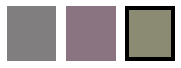

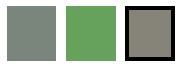

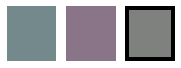

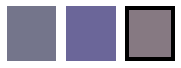

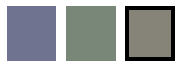

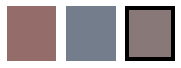

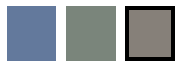

In [ ]:
corpus = bakeoff_corpus.read()

for i in range(2024):
  ex = next(corpus)
  if i in [5, 54, 258, 431, 737, 1116, 1424, 2024]:
    ex.display()

In [ ]:
df_transformer = pd.read_csv('cs224u-colors-bakeoff-entry.csv')
df_glove = pd.read_csv('cs224u-colors-bakeoff-entry-glove.csv')

#Glove Baseline Test

In [ ]:
dev_mod_glove = ContextualColorDescriber(
    dev_glove_vocab,
    embedding=dev_glove_embedding,
    early_stopping=True,
    save_csv = 'logs/glove_test.csv')

%time _ = dev_mod_glove.fit(dev_cols_train[:], dev_seqs_train[:])

/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 327.58109521865845


 Best Score: 0.42340425531914894


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 2 of 1000; error is 304.3509783744812


 Best Score: 0.4238297872340426


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 3 of 1000; error is 297.68395042419434


 Best Score: 0.43170212765957444


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 4 of 1000; error is 293.6111159324646


 Best Score: 0.4521276595744681


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 5 of 1000; error is 289.06933641433716


 Best Score: 0.4887234042553191


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 6 of 1000; error is 286.81177139282227


 Best Score: 0.5580851063829787


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 7 of 1000; error is 283.1424021720886


 Best Score: 0.6159574468085106


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 8 of 1000; error is 278.8053903579712


 Best Score: 0.6551063829787234


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 9 of 1000; error is 275.8278818130493


 Best Score: 0.6893617021276596


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 10 of 1000; error is 271.9464659690857


 Best Score: 0.7180851063829787


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 11 of 1000; error is 269.45283460617065


 Best Score: 0.7368085106382979


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 12 of 1000; error is 266.0232186317444


 Best Score: 0.7597872340425532


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 13 of 1000; error is 262.9786162376404


 Best Score: 0.7821276595744681


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 14 of 1000; error is 259.0933938026428


 Best Score: 0.7940425531914893


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 15 of 1000; error is 256.21489429473877


 Best Score: 0.7978723404255319


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 16 of 1000; error is 253.22943878173828


 Best Score: 0.8012765957446808


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 17 of 1000; error is 250.08966064453125


 Best Score: 0.806595744680851


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 18 of 1000; error is 247.5758671760559


 Best Score: 0.81


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 19 of 1000; error is 243.4214153289795


 Best Score: 0.8148936170212766


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 20 of 1000; error is 240.72919178009033


 Best Score: 0.8176595744680851


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 21 of 1000; error is 237.84553241729736


 Best Score: 0.8208510638297872


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 22 of 1000; error is 234.72047233581543


 Best Score: 0.8270212765957446


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 23 of 1000; error is 232.15978240966797


 Best Score: 0.831063829787234


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 24 of 1000; error is 229.7706847190857


 Best Score: 0.8317021276595745


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 25 of 1000; error is 226.56119585037231


 Best Score: 0.833404255319149


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 26 of 1000; error is 223.03620052337646


 Best Score: 0.8340425531914893


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 27 of 1000; error is 220.2443985939026


 Best Score: 0.8380851063829787


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 28 of 1000; error is 217.35300207138062


 Best Score: 0.8387234042553191


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 29 of 1000; error is 213.68365621566772


 Best Score: 0.8391489361702128


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 30 of 1000; error is 211.78592681884766


 Best Score: 0.8444680851063829


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 31 of 1000; error is 208.57571506500244/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 32 of 1000; error is 205.56649446487427


 Best Score: 0.8457446808510638


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 33 of 1000; error is 203.54917907714844


 Best Score: 0.8470212765957447


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 34 of 1000; error is 199.6723394393921


 Best Score: 0.8493617021276596


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 35 of 1000; error is 196.39367055892944/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 36 of 1000; error is 193.1368227005005


 Best Score: 0.85


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 37 of 1000; error is 190.7714924812317


 Best Score: 0.8506382978723405


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 38 of 1000; error is 188.28508758544922/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 39 of 1000; error is 184.38945174217224/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 40 of 1000; error is 182.41417837142944


 Best Score: 0.8519148936170213


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 41 of 1000; error is 179.2466526031494


 Best Score: 0.8525531914893617


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 42 of 1000; error is 176.15759825706482/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 43 of 1000; error is 173.1499490737915/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 44 of 1000; error is 170.2132225036621/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 45 of 1000; error is 167.48974657058716/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWa


 Best Score: 0.8529787234042553


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 48 of 1000; error is 158.4403784275055


 Best Score: 0.8546808510638297


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 49 of 1000; error is 155.99926567077637/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 50 of 1000; error is 153.138671875


 Best Score: 0.855531914893617


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 51 of 1000; error is 150.17009043693542


 Best Score: 0.8559574468085106


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 52 of 1000; error is 147.27643871307373/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 53 of 1000; error is 144.57079648971558


 Best Score: 0.8572340425531915


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 54 of 1000; error is 141.33150553703308


 Best Score: 0.8580851063829787


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 55 of 1000; error is 138.72401547431946/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 56 of 1000; error is 136.37435793876648/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 57 of 1000; error is 132.64733409881592/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 58 of 1000; error is 130.4223828315735/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeW


 Best Score: 0.8589361702127659


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 63 of 1000; error is 116.70892000198364


 Best Score: 0.8597872340425532


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 64 of 1000; error is 114.26966619491577/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 65 of 1000; error is 111.52819561958313/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 66 of 1000; error is 108.75630259513855/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 67 of 1000; error is 105.96496391296387/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: Runtime

CPU times: user 20min 59s, sys: 1min 36s, total: 22min 35s
Wall time: 22min 38s


In [ ]:
def create_bakeoff_submission(
        trained_model,
        output_filename='cs224u-colors-bakeoff-entry-glove.csv'):
    bakeoff_src_filename = os.path.join(
        "data", "colors", "cs224u-colors-test.csv")

    bakeoff_corpus = ColorsCorpusReader(bakeoff_src_filename)

    # This code just extracts the colors and texts from the new corpus:
    bakeoff_rawcols, bakeoff_texts = zip(*[
        [ex.colors, ex.contents] for ex in bakeoff_corpus.read()])

    # Original system function call; `trained_model` is your trained model:
    evaluation = evaluate_original_system(
        trained_model, bakeoff_rawcols, bakeoff_texts)

    evaluation['bakeoff_text'] = bakeoff_texts

    df = pd.DataFrame(evaluation)
    df.to_csv(output_filename)

if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass
    create_bakeoff_submission(dev_mod_glove)

In [ ]:
dev_trans.to_pickle('models/final_transformer.pkl')

In [ ]:
dev_mod_glove.to_pickle('models/final_glove.pkl')